# ASSIGNMENT -04 - CNN

## 1 : DATA LOADING AND PREPROCESSING

### Import necessary libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import kagglehub

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Download the dataset

In [ ]:
path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Path to dataset files:", path)

100%|██████████| 346M/346M [00:31<00:00, 11.6MB/s] 

Extracting files...


Path to dataset files: /Users/rajkaranyp/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


### DEFINING PATH 

In [4]:
# Define paths
data_dir = path
train_dir = os.path.join(data_dir, 'seg_train', 'seg_train')
test_dir = os.path.join(data_dir, 'seg_test', 'seg_test')

# Define image dimensions
img_height, img_width = 150, 150
batch_size = 32

# Create data generators with preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale test images

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Load validation data
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


### DSIPLAYING FEW IMAGES FROM DATASET

Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


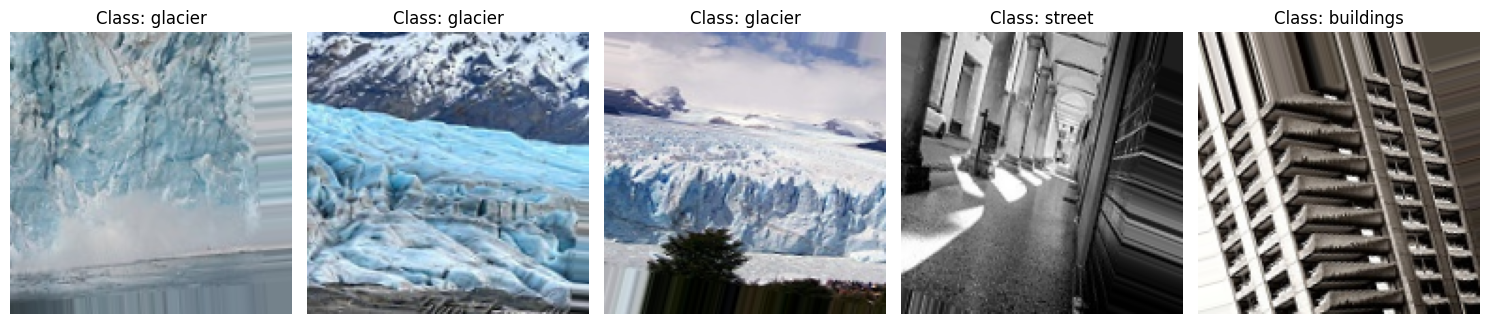

In [5]:
# Get class names
class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)

# Display sample images
def display_sample_images(generator, class_names, n=5):
    plt.figure(figsize=(15, 10))
    
    # Get a batch of images
    images, labels = next(generator)
    
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i])
        label_idx = np.argmax(labels[i])
        plt.title(f"Class: {class_names[label_idx]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

display_sample_images(train_generator, class_names)

## MODEL BUILDING

In [6]:
# Build the CNN model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),  # Dropout to prevent overfitting
        layers.Dense(num_classes, activation='softmax')  # Output layer
    ])
    
    return model

# Create the model
input_shape = (img_height, img_width, 3)  # RGB images
num_classes = len(class_names)
model = create_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,036,742 (72.62 MB)

 Trainable params: 19,036,742 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

## TRAINING THE MDODEL

In [7]:
epochs = 15

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

# Save the model
model.save('intel_image_classifier.h5')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 103s 292ms/step - accuracy: 0.4455 - loss: 1.3754 - val_accuracy: 0.6361 - val_loss: 0.9472
Epoch 2/15
  1/350 ━━━━━━━━━━━━━━━━━━━━ 1:22 235ms/step - accuracy: 0.5938 - loss: 0.9726

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


350/350 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.5938 - loss: 0.9726 - val_accuracy: 0.6340 - val_loss: 0.9496
Epoch 3/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 99s 283ms/step - accuracy: 0.6344 - loss: 0.9442 - val_accuracy: 0.6810 - val_loss: 0.8496
Epoch 4/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7500 - loss: 0.8420 - val_accuracy: 0.6825 - val_loss: 0.8646
Epoch 5/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 100s 286ms/step - accuracy: 0.6828 - loss: 0.8435 - val_accuracy: 0.7471 - val_loss: 0.7117
Epoch 6/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.8125 - loss: 0.6227 - val_accuracy: 0.7385 - val_loss: 0.7101
Epoch 7/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 102s 291ms/step - accuracy: 0.7178 - loss: 0.7528 - val_accuracy: 0.7256 - val_loss: 0.7415
Epoch 8/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.7500 - loss: 0.6673 - val_accuracy: 0.7130 - val_loss: 0.7769
Epoch 9/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 104s 297ms/step - accuracy: 0.7335 - loss: 0.7165 - val_accu

## VISUALIZATIONS

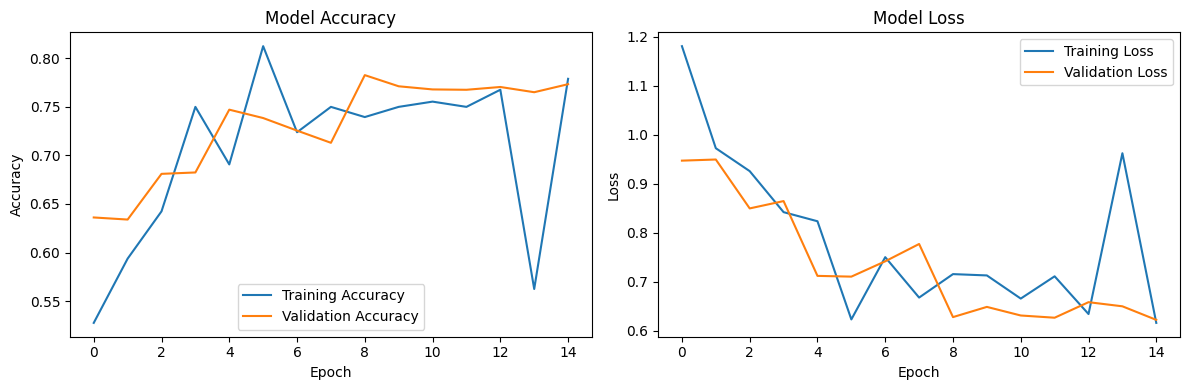

In [8]:
# Plot training history
def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

### EVALUATING THE MODEL USING TESTING SET

In [9]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.7978 - loss: 0.5138
Test accuracy: 0.8220
Test loss: 0.4833


### PREDICTIONS

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step


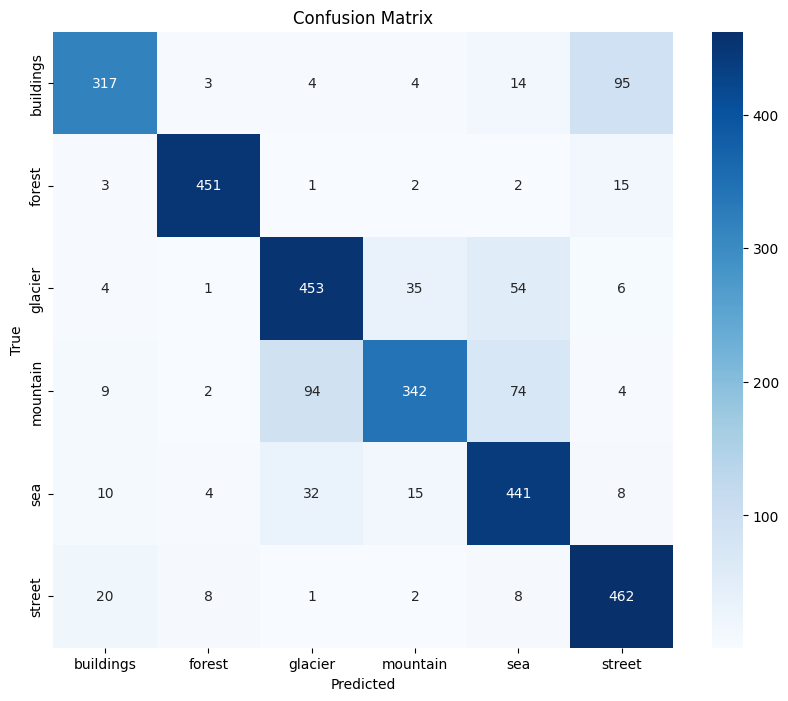

Classification Report:
              precision    recall  f1-score   support

   buildings       0.87      0.73      0.79       437
      forest       0.96      0.95      0.96       474
     glacier       0.77      0.82      0.80       553
    mountain       0.85      0.65      0.74       525
         sea       0.74      0.86      0.80       510
      street       0.78      0.92      0.85       501

    accuracy                           0.82      3000
   macro avg       0.83      0.82      0.82      3000
weighted avg       0.83      0.82      0.82      3000



In [10]:
# Get predictions
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

### Display misclassified images

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step


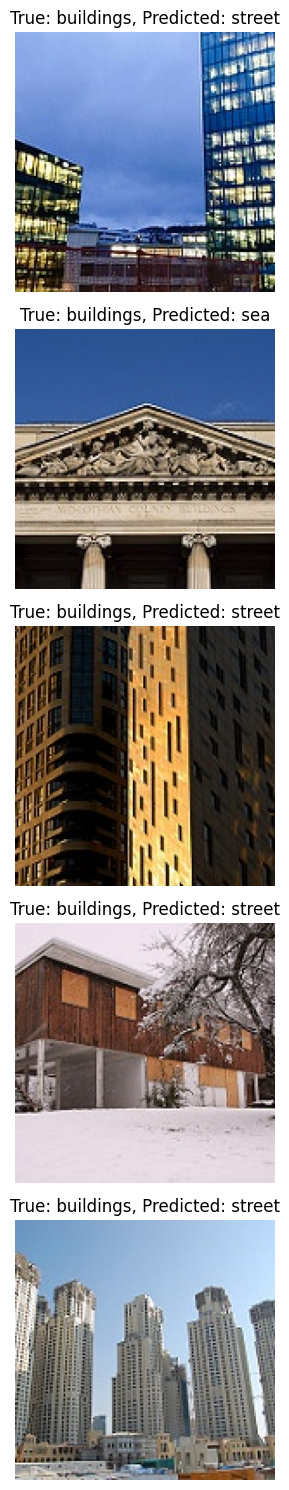

In [11]:
def display_misclassified_images(model, generator, class_names, n=5):
    generator.reset()
    images, labels = [], []
    
    # Collect images and labels
    for i in range(len(generator)):
        batch_images, batch_labels = next(generator)
        images.extend(batch_images)
        labels.extend(batch_labels)
        if len(images) >= 1000:  # Limit to avoid memory issues
            break
    
    images = np.array(images)
    labels = np.array(labels)
    
    # Get predictions
    predictions = model.predict(images)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)
    
    # Find misclassified samples
    misclassified_indices = np.where(pred_classes != true_classes)[0]
    
    if len(misclassified_indices) == 0:
        print("No misclassified images found in the sample.")
        return
    
    # Display misclassified images
    plt.figure(figsize=(15, 3*n))
    
    for i, idx in enumerate(misclassified_indices[:n]):
        plt.subplot(n, 1, i+1)
        plt.imshow(images[idx])
        plt.title(f"True: {class_names[true_classes[idx]]}, Predicted: {class_names[pred_classes[idx]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

display_misclassified_images(model, test_generator, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 150, 150, 3))
  warnings.warn(msg)


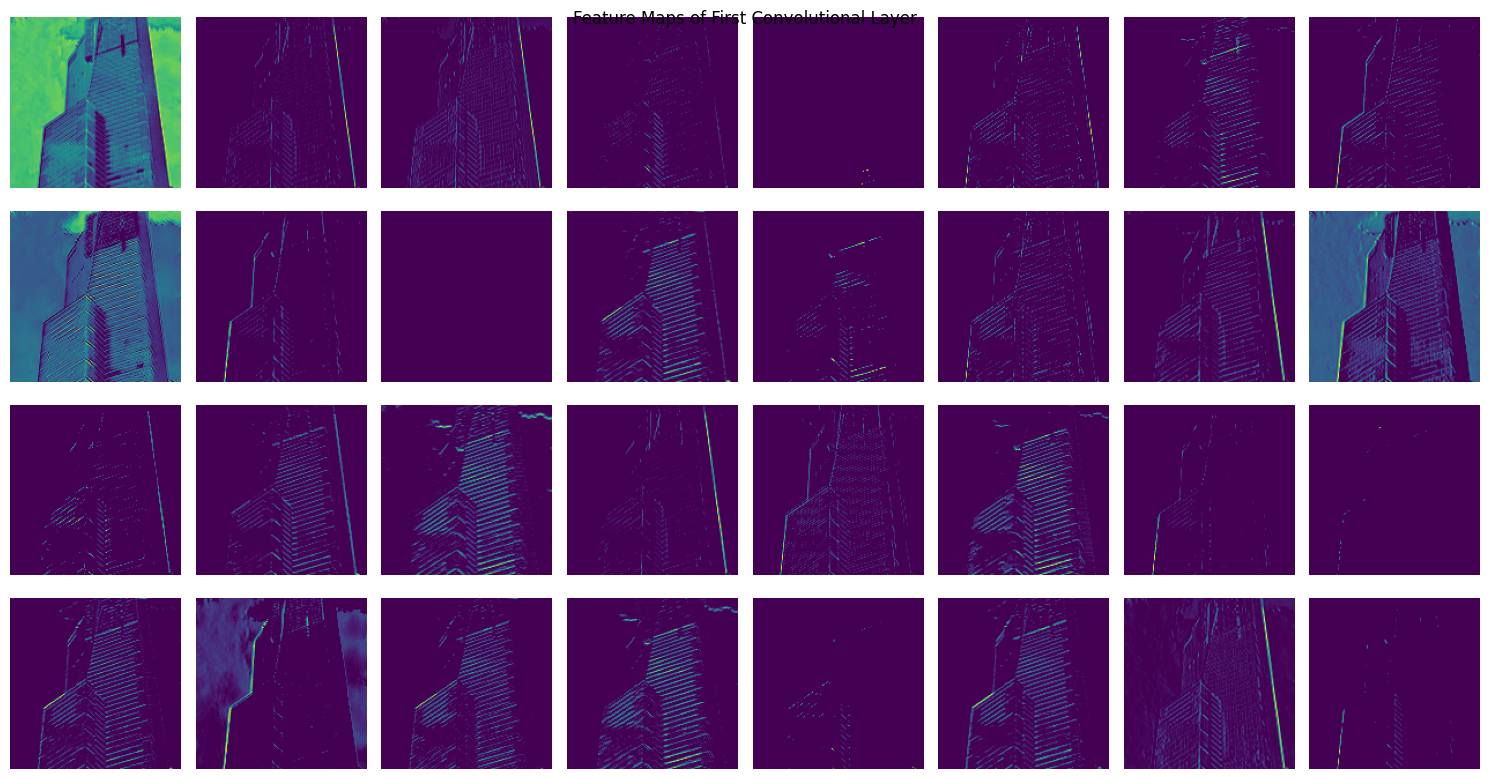

In [12]:
# Visualize feature maps of the first convolutional layer
def visualize_feature_maps(model, image):
    # Create a model that outputs the activations of the first conv layer
    feature_map_model = models.Model(inputs=model.inputs, outputs=model.layers[0].output)
    
    # Reshape the image to match the input shape of the model
    img = np.expand_dims(image, axis=0)
    
    # Get the feature maps
    feature_maps = feature_map_model.predict(img)
    
    # Plot the feature maps
    plt.figure(figsize=(15, 8))
    
    for i in range(min(32, feature_maps.shape[3])):
        plt.subplot(4, 8, i+1)
        plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle('Feature Maps of First Convolutional Layer')
    plt.show()

# Getting a sample image
test_generator.reset()
sample_images, _ = next(test_generator)
sample_image = sample_images[0]

# Visualize feature maps
visualize_feature_maps(model, sample_image)

In [13]:
# Model Performance Analysis
def analyze_model_performance():
    print("Model Performance Analysis:")
    print("--------------------------")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Calculate class-wise accuracy from confusion matrix
    class_accuracy = np.diag(cm) / np.sum(cm, axis=1)
    
    print("\nClass-wise Accuracy:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {class_accuracy[i]:.4f}")
    
    print("\nPotential Areas for Improvement:")
    print("1. Data Augmentation: Experiment with more aggressive augmentation techniques.")
    print("2. Model Architecture: Try deeper architectures or use transfer learning with pre-trained models like ResNet or EfficientNet.")
    print("3. Hyperparameter Tuning: Optimize learning rate, batch size, and regularization parameters.")
    print("4. Ensemble Methods: Combine predictions from multiple models for better performance.")
    print("5. Attention Mechanisms: Incorporate attention modules to focus on discriminative features.")

analyze_model_performance()

Model Performance Analysis:
--------------------------
Test Accuracy: 0.8220

Class-wise Accuracy:
buildings: 0.7254
forest: 0.9515
glacier: 0.8192
mountain: 0.6514
sea: 0.8647
street: 0.9222

Potential Areas for Improvement:
1. Data Augmentation: Experiment with more aggressive augmentation techniques.
2. Model Architecture: Try deeper architectures or use transfer learning with pre-trained models like ResNet or EfficientNet.
3. Hyperparameter Tuning: Optimize learning rate, batch size, and regularization parameters.
4. Ensemble Methods: Combine predictions from multiple models for better performance.
5. Attention Mechanisms: Incorporate attention modules to focus on discriminative features.


In [ ]:
# Install Keras Tuner if not already installed
!pip install keras-tuner

# Import necessary libraries
import keras_tuner as kt
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Define a model builder function with hyperparameters
def build_model(hp):
    # Initialize the model
    model = models.Sequential()
    
    # First Convolutional Block with tunable filters
    filters_1 = hp.Int('filters_1', min_value=32, max_value=128, step=32)
    kernel_size_1 = hp.Choice('kernel_size_1', values=[3, 5])
    model.add(layers.Conv2D(filters_1, (kernel_size_1, kernel_size_1), activation='relu', 
                           input_shape=(img_height, img_width, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Second Convolutional Block with tunable filters
    filters_2 = hp.Int('filters_2', min_value=64, max_value=256, step=64)
    kernel_size_2 = hp.Choice('kernel_size_2', values=[3, 5])
    model.add(layers.Conv2D(filters_2, (kernel_size_2, kernel_size_2), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Optional Third Convolutional Block
    if hp.Boolean('third_conv_block'):
        filters_3 = hp.Int('filters_3', min_value=128, max_value=512, step=128)
        model.add(layers.Conv2D(filters_3, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
    
    # Flatten the output
    model.add(layers.Flatten())
    
    # Tunable number of dense units
    units = hp.Int('units', min_value=128, max_value=512, step=128)
    model.add(layers.Dense(units, activation='relu'))
    
    # Tunable dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    model.add(layers.Dropout(dropout_rate))
    
    # Output layer
    model.add(layers.Dense(len(class_names), activation='softmax'))
    
    # Compile the model with tunable learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])
    
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to fit for each trial
    directory='hyperparameter_tuning',
    project_name='intel_image_classification'
)

# Display tuner search space summary
tuner.search_space_summary()

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Perform hyperparameter tuning
tuner.search(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,
    callbacks=[early_stopping]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Display the best hyperparameters
print("Best Hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

# Train the model with the best hyperparameters
history = best_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=15,
    callbacks=[early_stopping]
)

# Save the best model
best_model.save('best_intel_image_classifier.h5')

# Plot training history
def plot_tuned_model_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Tuned Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Tuned Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_tuned_model_history(history)

# Evaluate the tuned model on the test set
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Tuned Model - Test accuracy: {test_accuracy:.4f}")
print(f"Tuned Model - Test loss: {test_loss:.4f}")

Trial 5 Complete [00h 29m 59s]
val_accuracy: 0.5549569129943848

Best val_accuracy So Far: 0.7086925506591797
Total elapsed time: 02h 15m 25s
Best Hyperparameters:
filters_1: 64
kernel_size_1: 5
filters_2: 192
kernel_size_2: 3
third_conv_block: False
units: 384
dropout_rate: 0.30000000000000004
learning_rate: 0.001
optimizer: adam
filters_3: 384
Epoch 1/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 1342s 4s/step - accuracy: 0.4586 - loss: 1.8840 - val_accuracy: 0.6031 - val_loss: 0.9903
Epoch 2/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 80s 215ms/step - accuracy: 0.5625 - loss: 1.0827 - val_accuracy: 0.6060 - val_loss: 1.0125
Epoch 3/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 812s 2s/step - accuracy: 0.6074 - loss: 1.0163 - val_accuracy: 0.6415 - val_loss: 0.9495
Epoch 4/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.6562 - loss: 1.0837 - val_accuracy: 0.6311 - val_loss: 0.9851
Epoch 5/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 508s 1s/step - accuracy: 0.6640 - loss: 0.8969 - val_accuracy: 0.7105 - val_loss: 0.8015
Epo